In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dir_path = 'D:/competition/kaggle/riiid-test-answer-prediction/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

nrows = 100 * 10000
# nrows = None
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int16',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        })
# 没有读入user_answer[-1,0,1,2,3]

lectures = pd.read_csv(
                       dir_path + file_lectures, 
                       usecols=['lecture_id','tag','part','type_of'], 
                       nrows=nrows,
                       dtype={
                           'lecture_id': 'int16',
                           'tag': 'int16',
                           'part': 'int8',
                           'type_of': 'str'
                       }
                    )
questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part','tags'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                           'tags': 'str'
                       }
                    )

# Train

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int16  
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int16  
 6   answered_correctly              1000000 non-null  int8   
 7   prior_question_elapsed_time     976277 non-null   float32
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float32(1), int16(2), int32(1), int64(2), int8(2), object(1)
memory usage: 36.2+ MB


In [7]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False


In [8]:
train.tail()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
999995,999995,26482248,20949024,8803,0,29,1,14000.0,True
999996,999996,26516686,20949024,4664,0,30,1,17000.0,True
999997,999997,26537967,20949024,4108,0,31,0,18000.0,True
999998,999998,26590240,20949024,5014,0,32,0,6000.0,True
999999,999999,26605316,20949024,9828,0,33,0,46000.0,True


Text(0.5, 1.0, 'label dis')

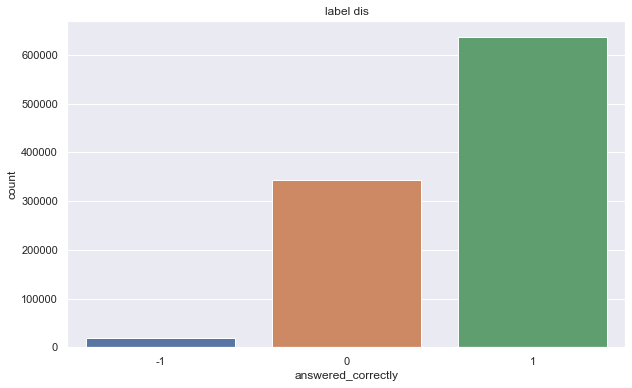

In [11]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='answered_correctly')
plt.title('label dis')

Text(0.5, 1.0, 'label dis')

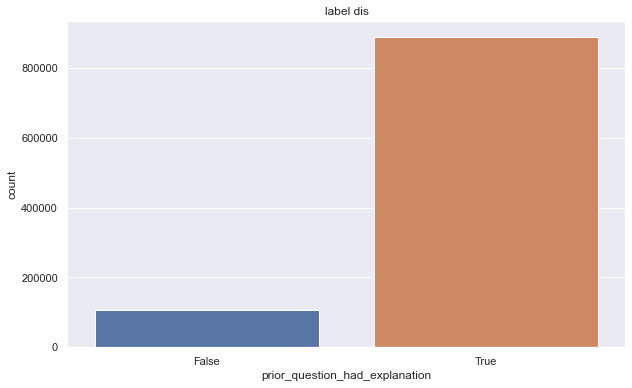

In [51]:
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='prior_question_had_explanation')
plt.title('label dis')

### content_id

Text(0.5, 1.0, 'content dis')

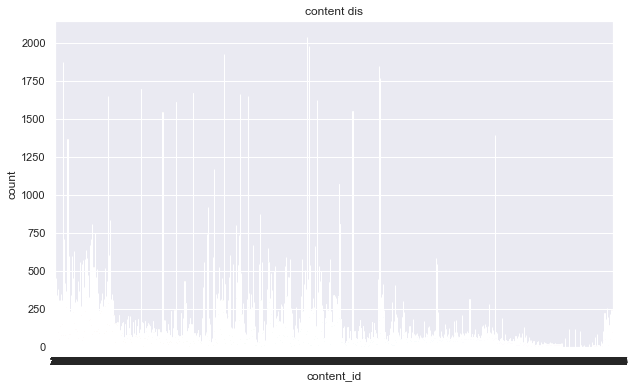

In [12]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='content_id')
plt.title('content dis')

In [22]:
train.groupby('content_id')['row_id'].count().sort_values()

content_id
12504       1
12945       1
12944       1
12940       1
12939       1
         ... 
7876     1847
175      1877
4120     1924
6173     1978
6116     2041
Name: row_id, Length: 13320, dtype: int64

In [38]:
a=train.groupby('content_id')['row_id'].count().sort_values()
len(a[a<=50])/len(a)

0.5168918918918919

<AxesSubplot:>

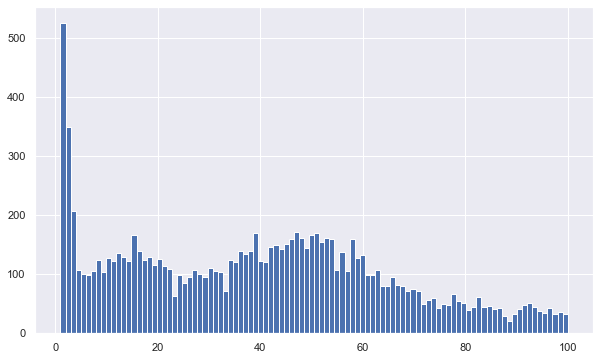

In [50]:
plt.figure(figsize=(10,6))
a[a<=100].hist(bins=100)

### user_id

In [5]:
train.groupby('user_id')['row_id'].count().sort_values().reset_index()

,user_id,row_id
0,19887248,1
1,1880240,1
2,15960740,2
3,2148001,2
4,1946295,3
...,...,...
3819,4421282,6962
3820,9418512,7482
3821,1283420,7569
3822,18122922,7593


In [6]:
train[train['user_id']==19887248]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
965193,965193,0,19887248,6368,0,0,0,NaN,NaN


In [7]:
train[train['user_id']==1946295]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
87900,87900,0,1946295,7900,0,0,1,NaN,NaN
87901,87901,23551,1946295,7876,0,1,0,26000.0,False
87902,87902,48795,1946295,175,0,2,1,20000.0,False


In [18]:
train[train['user_id']==7171715]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
366323,366323,0,7171715,4318,0,0,1,NaN,NaN
366324,366324,4274,7171715,5112,0,1,1,2000.0,False
366325,366325,7649,7171715,6143,0,2,0,1000.0,False
366326,366326,11134,7171715,5070,0,3,0,1000.0,False
366327,366327,14275,7171715,4554,0,4,1,1000.0,False
...,...,...,...,...,...,...,...,...,...
377144,377144,1380270562,7171715,9151,0,7735,1,20000.0,True
377145,377145,1380316755,7171715,3928,0,7736,1,7000.0,True
377146,377146,1380370703,7171715,4076,0,7737,1,23000.0,True
377147,377147,9717103856,7171715,10470,0,7738,1,30000.0,True


In [23]:
b=train.groupby(['user_id'])['row_id'].count().sort_values()# 用户互动次数
len(b[b==1])/len(b)#只互动一次的用户0.05%

0.0005230125523012552

In [22]:
b

,row_id
user_id,
19887248,1
1880240,1
15960740,2
2148001,2
1946295,3
...,...
4421282,6962
9418512,7482
1283420,7569


<AxesSubplot:xlabel='row_id'>

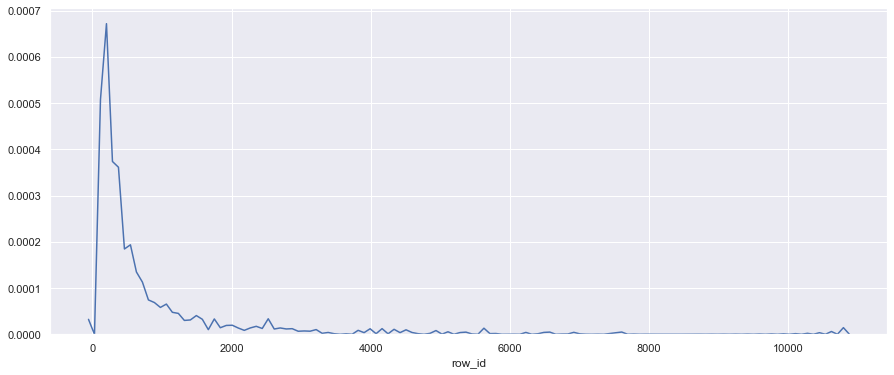

In [11]:
sns.set()
plt.figure(figsize=(15,6))
sns.distplot(b,hist=False)

<AxesSubplot:>

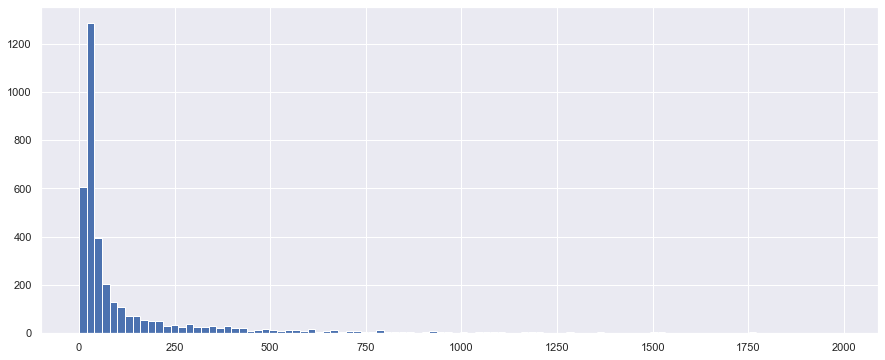

In [24]:
plt.figure(figsize=(15,6))
b[b<=2000].hist(bins=100)

### task_container_id

In [39]:
train.groupby('task_container_id')['row_id'].count().sort_values()

task_container_id
7739       1
6324       1
6325       1
6326       1
6327       1
        ... 
6       6722
5       6732
4       6753
15      7806
14      7845
Name: row_id, Length: 7740, dtype: int64

In [45]:
c=train.groupby('task_container_id')['row_id'].count().sort_values()
len(c[c==1])/len(c)

0.26356589147286824

<AxesSubplot:>

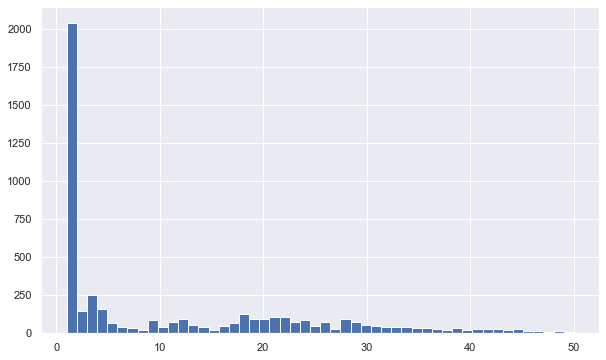

In [44]:
plt.figure(figsize=(10,6))
c[c<=50].hist(bins=50)

### prior_question_elapsed_time

Text(0.5, 1.0, 'content dis')

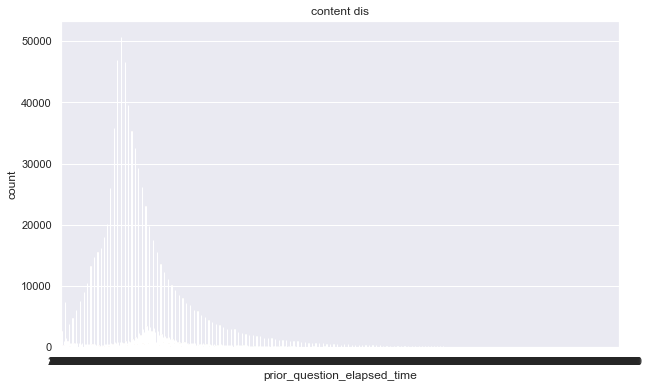

In [74]:
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='prior_question_elapsed_time')
plt.title('content dis')

In [72]:
train.groupby('prior_question_elapsed_time')['row_id'].count().sort_values()

prior_question_elapsed_time
212750.0        1
119600.0        1
150800.0        1
151500.0        1
168800.0        1
            ...  
15000.0     35889
19000.0     39580
18000.0     46550
16000.0     46949
17000.0     50744
Name: row_id, Length: 1659, dtype: int64

In [70]:
train.groupby('prior_question_elapsed_time')[['row_id']].count().reset_index().sort_values(by=['prior_question_elapsed_time'])

,prior_question_elapsed_time,row_id
0,0.0,2701
1,200.0,3
2,250.0,12
3,333.0,369
4,400.0,5
...,...,...
1654,295000.0,4
1655,296000.0,7
1656,297000.0,1
1657,298000.0,2


In [97]:
e=train[train['prior_question_elapsed_time']<=17000.0][['row_id']].count()
e[0]/len(train)

0.341002

### prior_question_had_explanation

In [25]:
set(train['prior_question_had_explanation'])

{'False', 'True', nan}

In [30]:
train['prior_question_had_explanation'].value_counts()

True     889887
False    106297
Name: prior_question_had_explanation, dtype: int64

In [38]:
train[train['prior_question_had_explanation'].isnull()].count()

row_id                            3816
timestamp                         3816
user_id                           3816
content_id                        3816
content_type_id                   3816
task_container_id                 3816
answered_correctly                3816
prior_question_elapsed_time          0
prior_question_had_explanation       0
dtype: int64

In [44]:
train['prior_question_had_explanation'].isnull().sum()

3816

In [45]:
from collections import Counter
Counter(train['prior_question_had_explanation'])

Counter({nan: 3816, 'False': 106297, 'True': 889887})

## answer correctness rate

### questions+lectures

In [45]:
df1=train.groupby(['user_id'])['answered_correctly'].agg([np.mean,np.std]).reset_index()
df1

,user_id,mean,std
0,115,0.695652,0.465215
1,124,0.233333,0.430183
2,2746,0.500000,0.606977
3,5382,0.632812,0.530504
4,8623,0.598214,0.544585
...,...,...,...
3819,20913319,0.560096,0.577693
3820,20913864,0.333333,0.483046
3821,20938253,0.575701,0.534720
3822,20948951,0.607843,0.493089


In [55]:
train[train['user_id']==115]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False
5,5,157063,115,156,0,5,1,5000.0,False
6,6,176092,115,51,0,6,1,17000.0,False
7,7,194190,115,50,0,7,1,17000.0,False
8,8,212463,115,7896,0,8,1,16000.0,False
9,9,230983,115,7863,0,9,1,16000.0,False


In [48]:
df1.sort_values(by='mean')

,user_id,mean,std
3534,19172765,-0.013072,0.688122
226,1360462,0.000000,0.000000
3661,19887248,0.000000,NaN
1887,10442781,0.033333,0.182574
3237,17636315,0.066667,0.253708
...,...,...,...
1392,7788970,0.966667,0.182574
543,3126556,0.966667,0.182574
3510,19087497,0.967742,0.179605
1339,7528236,0.967742,0.179605


In [49]:
train[train['user_id']==19172765]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
913836,913836,0,19172765,4603,0,0,0,NaN,NaN
913837,913837,28910,19172765,4324,0,1,0,18000.0,False
913838,913838,59340,19172765,846,0,2,0,24000.0,False
913839,913839,80977,19172765,4981,0,3,1,28000.0,False
913840,913840,109829,19172765,5296,0,4,1,19000.0,False
...,...,...,...,...,...,...,...,...,...
913984,913984,6403824412,19172765,27683,1,91,-1,NaN,False
913985,913985,6475599829,19172765,18704,1,92,-1,NaN,False
913986,913986,6573882978,19172765,22357,1,93,-1,NaN,False
913987,913987,7123212945,19172765,19224,1,94,-1,NaN,False


In [50]:
df1[df1['user_id']==7171715] #做题最多的人

,user_id,mean,std
1267,7171715,0.258082,0.44368


### questions only

In [51]:
train_questions=train[train['content_type_id']==0]
df2 = train_questions.groupby(['user_id'])['answered_correctly'].agg([np.mean,np.std]).reset_index()
df2.sort_values(by='mean')

,user_id,mean,std
3661,19887248,0.000000,NaN
226,1360462,0.000000,0.000000
1887,10442781,0.033333,0.182574
2372,12975989,0.066667,0.253708
3237,17636315,0.066667,0.253708
...,...,...,...
543,3126556,0.966667,0.182574
1392,7788970,0.966667,0.182574
1339,7528236,0.967742,0.179605
3510,19087497,0.967742,0.179605


<AxesSubplot:xlabel='mean'>

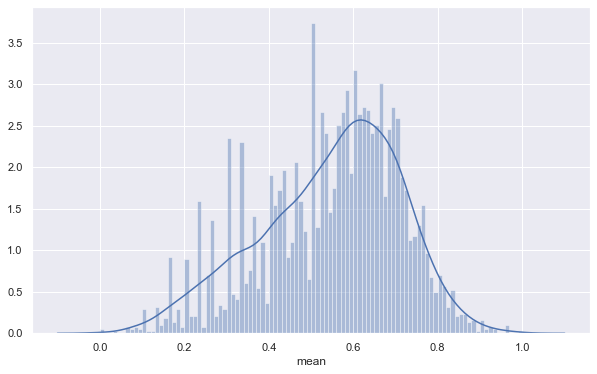

In [65]:
sns.set()
plt.figure(figsize=(10,6))
sns.distplot(df2['mean'],bins=100)
# df2['mean'].plot.density()

<AxesSubplot:xlabel='std'>

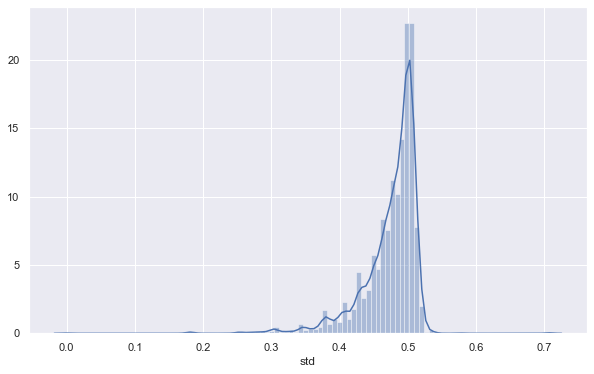

In [66]:
plt.figure(figsize=(10,6))
sns.distplot(df2['std'],bins=100)#二分类算标注差好像没什么用，0.6的准确率：标准差0.4899

In [52]:
df2[df2['user_id']==7171715] #做题最多的人,去掉lecture，也没提高多少，太惨了老哥

,user_id,mean,std
1267,7171715,0.261462,0.439451


### lectures only

In [53]:
train_questions=train[train['content_type_id']==1]
df3 = train_questions.groupby(['user_id'])['row_id'].count().reset_index()
df3.sort_values(by='row_id')

,user_id,row_id
0,2746,1
545,7314679,1
1242,17210091,1
1243,17216952,1
1244,17258119,1
...,...,...
1130,15632472,170
1297,18122922,180
5,24418,181
703,9418512,221


In [54]:
df2[df2['user_id']==19594546]

,user_id,mean,std
3602,19594546,0.704142,0.456472


In [29]:
# from collections import Counter
# Counter(train[train['user_id']==19594546]['content_type_id'])
train[train['user_id']==19594546]['content_type_id'].value_counts()#也没看多少lecture，低于平均LQ比

0    5070
1     306
Name: content_type_id, dtype: int64

### based on content_id

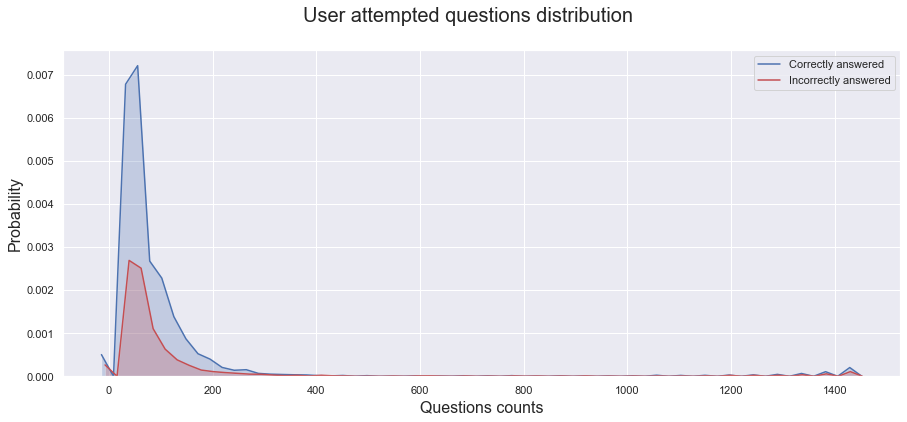

In [46]:
df = train[train['content_type_id'] == 0]

df2 = df[df['answered_correctly'] == 1]
df3 = df[df['answered_correctly'] == 0]

df2 = df2.groupby(by='content_id').count()
df3 = df3.groupby(by='content_id').count()

fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(df2['row_id'], shade=True, gridsize=50, color='b', legend=False)
fig = sns.kdeplot(df3['row_id'], shade=True, gridsize=50, color='r', legend=False)

fig.figure.suptitle("User attempted questions distribution", fontsize = 20)
plt.xlabel('Questions counts', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.legend(['Correctly answered','Incorrectly answered'])

### based on user_id

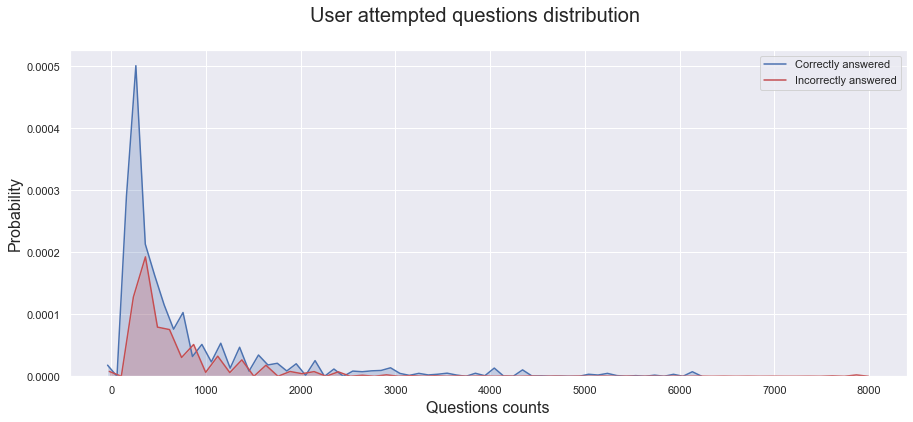

In [47]:
df = train[train['content_type_id'] == 0]

df2 = df[df['answered_correctly'] == 1]
df3 = df[df['answered_correctly'] == 0]

df2 = df2.groupby(by='user_id').count()
df3 = df3.groupby(by='user_id').count()

fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(df2['row_id'], shade=True, gridsize=50, color='b', legend=False)
fig = sns.kdeplot(df3['row_id'], shade=True, gridsize=50, color='r', legend=False)

fig.figure.suptitle("User attempted questions distribution", fontsize = 20)
plt.xlabel('Questions counts', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.legend(['Correctly answered','Incorrectly answered'])

# Questions

In [48]:
questions.head()

,question_id,bundle_id,part,tags
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,2,1,131 101 162 92
3,3,3,1,131 149 162 29
4,4,4,1,131 5 162 38


In [49]:
questions.tail()

,question_id,bundle_id,part,tags
13518,13518,13518,5,14
13519,13519,13519,5,8
13520,13520,13520,5,73
13521,13521,13521,5,125
13522,13522,13522,5,55


In [50]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  13523 non-null  int16 
 1   bundle_id    13523 non-null  int16 
 2   part         13523 non-null  int8  
 3   tags         13522 non-null  object
dtypes: int16(2), int8(1), object(1)
memory usage: 171.8+ KB


### bundle_id

In [59]:
len(set(questions.bundle_id))

9765

In [62]:
questions.bundle_id.isnull().sum()

0

In [66]:
a=questions.groupby('bundle_id')[['question_id']].count()
a[a['question_id']!=1]

,question_id
bundle_id,
1400,3
1403,3
1406,3
1409,3
1412,3
...,...
13238,3
13241,3
13244,3


In [67]:
a[a['question_id']==3]

,question_id
bundle_id,
1400,3
1403,3
1406,3
1409,3
1412,3
...,...
13238,3
13241,3
13244,3


In [68]:
a[a['question_id']==2]

,question_id
bundle_id,
2180,2
2860,2
7027,2
7029,2
7031,2
...,...
11559,2
11631,2
11633,2


In [69]:
a[a['question_id']==5]

,question_id
bundle_id,
6940,5
6961,5
6966,5
6971,5
6976,5
...,...
11679,5
11684,5
11689,5


In [70]:
a[a['question_id']==4]

,question_id
bundle_id,
6481,4
6485,4
6489,4
6493,4
6497,4
...,...
11623,4
11627,4
11642,4


### part

In [74]:
from collections import Counter
Counter(questions.part)

Counter({1: 992, 2: 1647, 3: 1562, 4: 1439, 5: 5511, 6: 1212, 7: 1160})

### tags

In [83]:
questions.tags #字符串

0         51 131 162 38
1             131 36 81
2        131 101 162 92
3        131 149 162 29
4          131 5 162 38
              ...      
13518                14
13519                 8
13520                73
13521               125
13522                55
Name: tags, Length: 13523, dtype: object

In [117]:
questions.tags.nunique()

1519

In [119]:
questions[questions['tags'].isnull()]

,question_id,bundle_id,part,tags
10033,10033,10033,6,NaN


In [105]:
questions.tags.map(lambda x: str(x).split(' '))

0         [51, 131, 162, 38]
1              [131, 36, 81]
2        [131, 101, 162, 92]
3        [131, 149, 162, 29]
4          [131, 5, 162, 38]
                ...         
13518                   [14]
13519                    [8]
13520                   [73]
13521                  [125]
13522                   [55]
Name: tags, Length: 13523, dtype: object

In [85]:
# encoding方法
# questions['tags_51'] = questions['tags'].map(lambda x: 1 if '51' in str(x) else 0 )

In [114]:
tags_list = []
for tag in questions.tags.map(lambda x: str(x).split(' ')):
    tags_list += tag
set(tags_list)

{'0',
 '1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '15',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '16',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '17',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '18',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',


In [115]:
len(set(tags_list))

189

In [116]:
tags_dict=dict(Counter(tags_list))
tags_dict=sorted(tags_dict.items(),key=lambda x:x[1],reverse= True)
tags_dict

[('92', 2269),
 ('38', 2256),
 ('81', 1969),
 ('29', 1707),
 ('136', 1033),
 ('162', 914),
 ('102', 789),
 ('8', 751),
 ('143', 712),
 ('131', 650),
 ('73', 630),
 ('21', 597),
 ('53', 544),
 ('82', 527),
 ('74', 476),
 ('106', 457),
 ('1', 422),
 ('96', 378),
 ('12', 339),
 ('97', 332),
 ('67', 327),
 ('55', 312),
 ('27', 302),
 ('122', 298),
 ('79', 296),
 ('42', 294),
 ('10', 293),
 ('118', 265),
 ('135', 260),
 ('98', 259),
 ('84', 235),
 ('14', 232),
 ('173', 226),
 ('35', 215),
 ('90', 214),
 ('109', 210),
 ('16', 210),
 ('155', 209),
 ('157', 206),
 ('100', 203),
 ('89', 203),
 ('37', 202),
 ('160', 198),
 ('62', 194),
 ('103', 192),
 ('144', 162),
 ('113', 156),
 ('161', 146),
 ('2', 144),
 ('163', 132),
 ('91', 129),
 ('9', 124),
 ('145', 123),
 ('114', 121),
 ('107', 120),
 ('32', 119),
 ('76', 118),
 ('137', 115),
 ('140', 112),
 ('88', 112),
 ('148', 110),
 ('60', 109),
 ('30', 105),
 ('176', 105),
 ('138', 104),
 ('18', 104),
 ('41', 100),
 ('20', 100),
 ('116', 100),
 ('1

# Lectures

In [120]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [121]:
lectures.tail()

,lecture_id,tag,part,type_of
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept
417,32736,82,3,concept


In [124]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int16 
 1   tag         418 non-null    int16 
 2   part        418 non-null    int8  
 3   type_of     418 non-null    object
dtypes: int16(2), int8(1), object(1)
memory usage: 5.4+ KB


### type_of

In [125]:
lectures.type_of.unique()

array(['concept', 'solving question', 'intention', 'starter'],
      dtype=object)

In [126]:
from collections import Counter
Counter(lectures.type_of)

Counter({'concept': 222,
         'solving question': 186,
         'intention': 7,
         'starter': 3})

### part

In [127]:
Counter(lectures.part)

Counter({5: 143, 1: 54, 6: 83, 2: 56, 7: 32, 3: 19, 4: 31})

### tag

In [130]:
Counter(lectures.tag) #lectures.tag没有组合

Counter({159: 4,
         70: 5,
         45: 3,
         79: 4,
         156: 4,
         114: 5,
         179: 4,
         134: 6,
         93: 2,
         80: 3,
         98: 3,
         101: 4,
         33: 3,
         74: 6,
         60: 3,
         181: 4,
         43: 3,
         4: 4,
         109: 4,
         89: 3,
         142: 2,
         140: 2,
         104: 2,
         1: 4,
         65: 3,
         155: 1,
         26: 4,
         178: 2,
         173: 5,
         7: 3,
         147: 2,
         171: 1,
         78: 2,
         62: 6,
         64: 4,
         141: 3,
         124: 2,
         161: 6,
         24: 2,
         23: 2,
         152: 4,
         8: 4,
         94: 5,
         119: 5,
         37: 2,
         177: 3,
         54: 3,
         157: 4,
         132: 2,
         6: 2,
         67: 1,
         123: 3,
         50: 2,
         25: 3,
         175: 2,
         116: 6,
         136: 7,
         20: 2,
         129: 3,
         127: 3,
         53: 4,

In [136]:
lectures.groupby('tag')['lecture_id'].count().sort_values()

tag
187    1
83     1
90     1
57     1
99     1
      ..
161    6
27     6
134    6
116    6
136    7
Name: lecture_id, Length: 151, dtype: int64